# DMS and DUAL-IPA allele overlap

Very limited number of gene/alleles overlapped, skip for Pillar paper.

In [4]:
# imports
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sns.set_style(style='white')
sys.path.append("../..")
from utils import *

In [17]:
dualipa_final_df = pl.read_csv("/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/dual_ipa/3_outputs/annotated_perturbation_scores.csv", infer_schema_length=100000)
dualipa_final_df = dualipa_final_df.with_columns(
    pl.col("nuc_loc").cast(pl.Int64).alias("nuc_loc")
)
# [c for c in dualipa_final_df.columns if "abun" in c]

In [6]:
pillar_clinvar_df = pl.read_csv(
    "../../../1_allele_collection/1_inputs/raw_inputs/pillar_data/final_pillar_data_with_clinvar_gnomad_wREVEL_wAM_gold_standards_080425.csv",
    schema_overrides={
        "Chrom": pl.String, 
        'aa_pos': pl.String, 
        'auth_reported_score': pl.String
    },
    infer_schema_length=10000
).with_columns(
    pl.col("Gene").str.replace_all(r"[^a-zA-Z0-9]", "").alias("Gene"),
    pl.col("hgvs_p").str.replace_all(r"[^a-zA-Z0-9\.]", "").alias("hgvs_p")
).with_columns(
    pl.col("Gene").str.replace_all("CHK2", "CHEK2").alias("Gene"),
    pl.col("Chrom").cast(pl.String).str.strip_chars().alias("Chrom"),
    pl.col("hg38_start").alias("nuc_loc"),
    pl.col("ref_allele").cast(pl.String).str.strip_chars().alias("ref_allele"),
    pl.col("alt_allele").cast(pl.String).str.strip_chars().alias("alt_allele")
).with_columns(
    pl.concat_str(
        [
            pl.col("Gene"),
            pl.col("hgvs_p").str.replace(r"^p\.", "") # remove leading "p." from hgvs_p
        ],
        separator="_"
    ).alias("gene_variant")
)

## filter the SNP variants only
pillar_clinvar_single_aa_df = pillar_clinvar_df.filter(
    (pl.col("consequence").str.contains("sense")) & \
    (pl.col("ref_allele").str.len_chars()==1) & (pl.col("alt_allele").str.len_chars()==1) & \
    (pl.col("hg38_start").is_not_null()) & (pl.col("hg38_end").is_not_null())
).drop_nulls(subset="hgvs_p").with_columns(
    pl.col("hgvs_p").str.split(".").list.get(-1).alias("aa_change"),
    pl.lit(True).alias("pillar_tested")
)
print("Filtered missense/SNP pillar dataset shape:", pillar_clinvar_single_aa_df.shape)

pillar_clinvar_single_aa_df = pillar_clinvar_single_aa_df.sort(
    "gene_variant", "gnomad_MAF", descending=[False,False]
)
print("Number of unique genes Pillar ALL:", pillar_clinvar_df.unique(subset="Gene").shape[0])
print("Number of unique genes Pillar SNP:", pillar_clinvar_single_aa_df.unique(subset="Gene").shape[0])
print("Number of unique gene variants:", pillar_clinvar_single_aa_df.unique(subset="gene_variant").shape[0])
display(pillar_clinvar_single_aa_df) #.filter(pl.col("Ref_seq_transcript_ID").str.contains("NC_"))

Filtered missense/SNP pillar dataset shape: (176277, 109)
Number of unique genes Pillar ALL: 40
Number of unique genes Pillar SNP: 40
Number of unique gene variants: 94200


ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,simplified_consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transcript_ID,Ref_seq_transcript_ID,Model_system,Assay Type ontology term,Phenotype Measured ontology term,…,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Classification by multifactorial model_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant,aa_change,pillar_tested
str,str,str,i64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,bool
"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA""",756,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""","""C""","""A""","""148.0""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""missense_variant""","""0.9495""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-1""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""protein stability assay (BAO_0…","""fluorescence intensity (BAO_00…",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.483509e6,"""ASPA_Ala148Asp""","""Ala148Asp""",true
"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""","""C""","""A""","""148.0""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""missense_variant""","""-0.1191""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-b-1""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""cell viability assay (BAO_0003…","""survival rate (OBI_0000789)""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.483509e6,"""ASPA_Ala148Asp""","""Ala148Asp""",true
"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA""",756,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""G""",null,"""443""","""C""","""G""","""148.0""","""A""","""G""","""c.443C>G""","""p.Ala148Gly""","""missense_variant""","""missense_variant""","""0.2662""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00000657-a-1""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""protein stability assay (BAO_0…","""fluorescence intensity (BAO_00…",…,null,null,null,null,null,null,nul

Text(0.5, 1.0, '26 variants overlapped\nbetween VarChAMP DUAL-IPA and Pillar dataset')

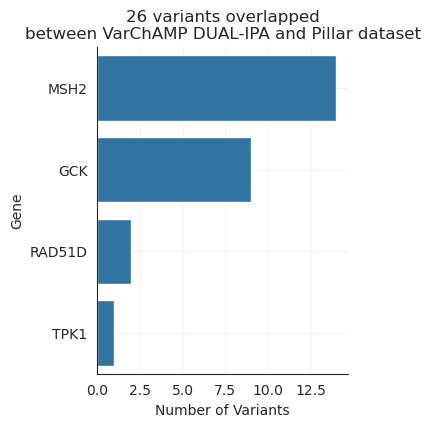

In [13]:
dualipa_pillar_df = dualipa_final_df.with_columns(
    pl.col("nuc_loc").cast(pl.Float64).alias("nuc_loc")
).join(
    pillar_clinvar_single_aa_df,
    on=["Chrom", "nuc_loc", "ref_allele", "alt_allele"],
    suffix="_pp",
    how="inner",
)
g = sns.catplot(data=dualipa_pillar_df.unique(subset="gene_variant").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
            x="Number of Variants", y="Gene", kind="bar", height=4, aspect=.9)
g.ax.grid(alpha=.2)
plt.title(f"{dualipa_pillar_df.unique('gene_variant').shape[0]} variants overlapped\nbetween VarChAMP DUAL-IPA and Pillar dataset")

,symbol,clinvar_clnsig_clean,total_counts,hit_counts,hit_perc,total_counts_all
0,GCK,1_Pathogenic,14,6,42.857143,18
1,GCK,3_Conflicting,2,2,100.000000,18
2,GCK,5_Others,2,0,0.000000,18
3,MSH2,1_Pathogenic,4,0,0.000000,14
4,MSH2,2_Benign,1,0,0.000000,14
5,MSH2,3_Conflicting,5,0,0.000000,14
6,MSH2,4_VUS,4,0,0.000000,14
7,RAD51D,2_Benign,2,0,0.000000,2
8,TPK1,1_Pathogenic,1,0,0.000000,1


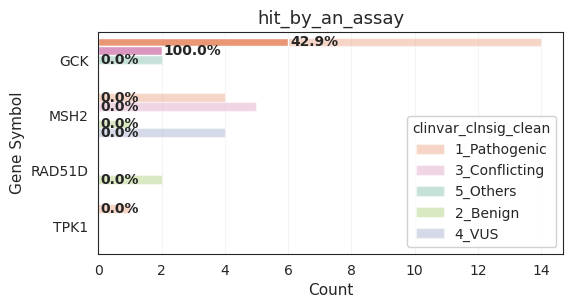

In [10]:
plot_gene_level_summary(
    dualipa_pillar_df.with_columns(
        (
            (pl.col("dualipa_abun_change")=="Y")
        ).alias("hit_by_an_assay"),
        pl.col("clinvar_clnsig_clean").replace("6_No_ClinVar", "5_Others")
    ),
    assay="hit_by_an_assay", 
    cat="clinvar_clnsig_clean", 
    palette=palette_dict["clinvar_clnsig_clean"]
)

In [26]:
dualipa_pillar_df.filter(
    pl.col("gene_allele").str.contains("MSH2")
)["gene_allele","dualipa_abun_score","dualipa_abun_change"]

gene_allele,dualipa_abun_score,dualipa_abun_change
str,f64,str
"""MSH2_Ala305Thr""",-2.462572,"""Uncertain"""
"""MSH2_Ala714Val""",-3.016396,"""Uncertain"""
"""MSH2_Arg524Pro""",-0.972095,"""Uncertain"""
"""MSH2_Arg96His""",-4.096816,"""Uncertain"""
"""MSH2_Gln409Lys""",-2.944787,"""Uncertain"""
…,…,…
"""MSH2_Leu440Pro""",-0.006447,"""N"""
"""MSH2_Leu687Pro""",-1.262916,"""Uncertain"""
"""MSH2_Leu92Val""",-0.899797,"""Uncertain"""


<Axes: xlabel='Gene', ylabel='dualipa_abun_score'>

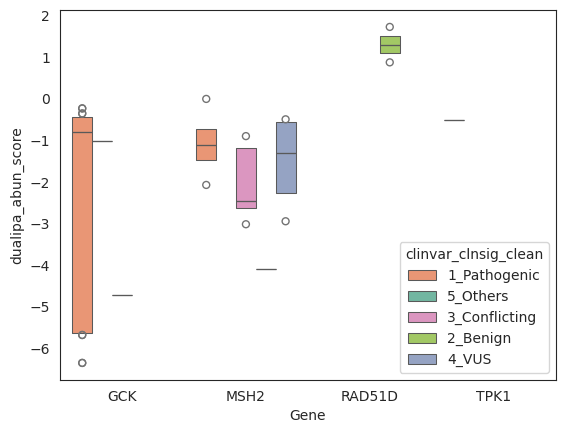

In [20]:
sns.boxenplot(
    data=dualipa_pillar_df.with_columns(
        (
            (pl.col("dualipa_abun_change")=="Y")
        ).alias("hit_by_an_assay"),
        pl.col("clinvar_clnsig_clean").replace("6_No_ClinVar", "5_Others")
    ).to_pandas(),
    x="Gene",
    y="dualipa_abun_score",
    hue="clinvar_clnsig_clean", 
    palette=palette_dict["clinvar_clnsig_clean"]
)